## Bike Sharing Demand Prediction

### Data
Source: https://dacon.io/competitions/open/235576/data
#### Train/Test Dataset
* Columns:
    * `id`: unique iD
    * `hour`: time of day
    * `temperature`
    * `precipitation`: 1 if raining, 0 if not
    * `windspeed`: average windspeed
    * `humidity`
    * `visibility`: visibility based on weather conditions
    * `ozone`
    * `pm10`: fine dust pm (size between 1/5 and 1/7 of the width of hair)
    * `pm2.5`: fine dust pm (size between 1/20 and 1/30 of the width of hair)
    * `count`: number of bike sharing demands corresponding to each hour, included in test data only
    

### Score Measures
* Evaluated with RMSE

## Data Loading

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train = pd.read_csv('data/따릉이/train.csv')
test = pd.read_csv('data/따릉이/test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [ ]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [ ]:
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [ ]:
test.isnull().sum()

id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [ ]:
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

## EDA, feature engineering

In [ ]:
def rename_column(x):
    if x != 'id' or 'hour' or 'count':
        x = x.replace('hour_bef_', '')
    return x

train.columns = map(rename_column, train.columns)
test.columns = map(rename_column, test.columns)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1459 non-null   int64  
 1   hour           1459 non-null   int64  
 2   temperature    1459 non-null   float64
 3   precipitation  1459 non-null   float64
 4   windspeed      1459 non-null   float64
 5   humidity       1459 non-null   float64
 6   visibility     1459 non-null   float64
 7   ozone          1459 non-null   float64
 8   pm10           1459 non-null   float64
 9   pm2.5          1459 non-null   float64
 10  count          1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


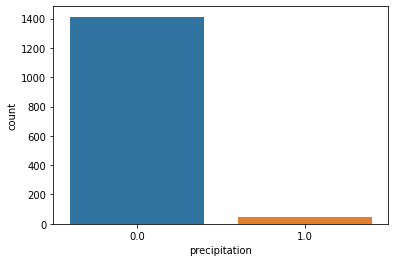

In [ ]:
sns.countplot(data = train, x = 'precipitation')

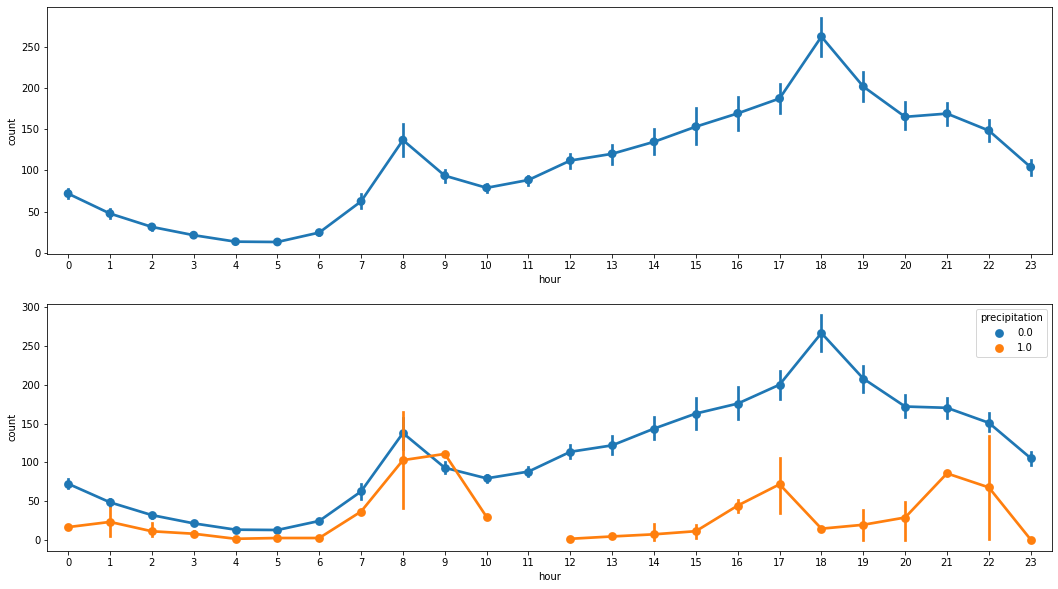

In [ ]:
fig, axes = plt.subplots(nrows = 2, figsize = (18, 10))

sns.pointplot(data = train, x = 'hour', y = 'count', ax = axes[0])
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'precipitation', ax = axes[1])

* demand peaks during the start & end of work hours (8am, 6pm)
* similar patterns of demand when raining, but shows signs of decrease at around 6 pm
* use both precipitation and hour as predicting variable

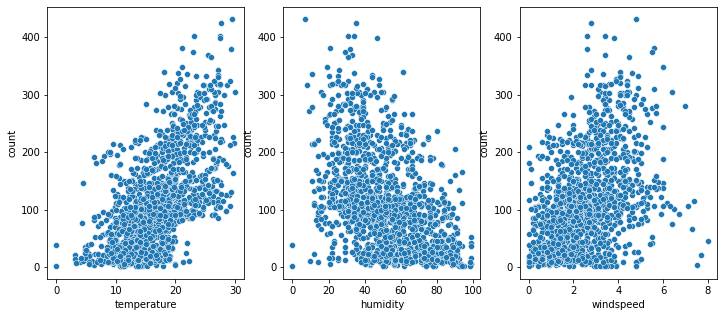

In [ ]:
# observe temperature, humidity & windspeed

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))

sns.scatterplot(data = train, x = 'temperature', y = 'count', ax = axes[0])
sns.scatterplot(data = train, x = 'humidity', y = 'count', ax = axes[1])
sns.scatterplot(data = train, x = 'windspeed', y = 'count', ax = axes[2])

In [ ]:
print(len(train[train['temperature']==0]))
print(len(train[train['humidity']==0]))
print(len(train[train['windspeed']==0]))

2
2
12


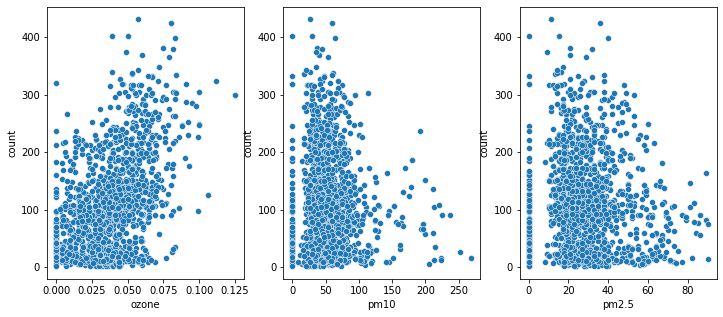

In [ ]:
# observe ozone, pm10, pm2.5

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))

sns.scatterplot(data = train, x = 'ozone', y = 'count', ax = axes[0])
sns.scatterplot(data = train, x = 'pm10', y = 'count', ax = axes[1])
sns.scatterplot(data = train, x = 'pm2.5', y = 'count', ax = axes[2])

In [ ]:
print(len(train[train['ozone']==0]))
print(len(train[train['pm10']==0]))
print(len(train[train['pm2.5']==0]))

76
90
117


* null values are replaced with 0

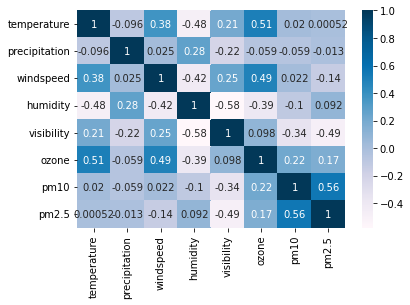

In [ ]:
corr_data = train[['temperature', 'precipitation', 'windspeed', 'humidity', 'visibility', 'ozone', 'pm10', 'pm2.5']]
colormap = plt.cm.PuBu
sns.heatmap(corr_data.corr(), annot=True, cmap = colormap)

* high correlation between pm10&pm2.5, windspeed&ozone, and temperature&ozone

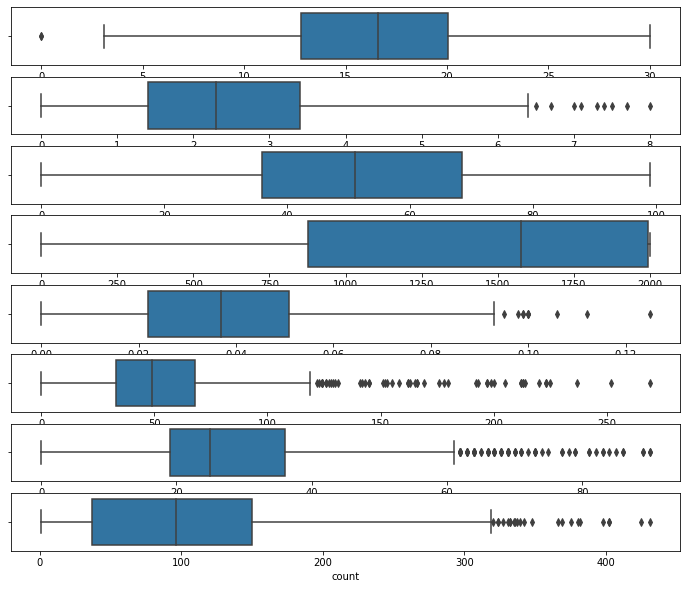

In [ ]:
fig, axes = plt.subplots(nrows=8, figsize = (12, 10))

sns.boxplot(data = train, x = 'temperature', ax = axes[0])
sns.boxplot(data = train, x = 'windspeed', ax = axes[1])
sns.boxplot(data = train, x = 'humidity', ax = axes[2])
sns.boxplot(data = train, x = 'visibility', ax = axes[3])
sns.boxplot(data = train, x = 'ozone', ax = axes[4])
sns.boxplot(data = train, x = 'pm10', ax = axes[5])
sns.boxplot(data = train, x = 'pm2.5', ax = axes[6])
sns.boxplot(data = train, x = 'count', ax = axes[7])

In [ ]:
# IQR filtering
def remove_outliers_iqr(data, cols):
    for col in cols:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (IQR * 1.5)
        upper_bound = Q3 + (IQR * 1.5)

        outliers = data[
            (data[col]<lower_bound)|(data[col]>upper_bound)]
        no_outliers = data[
            (data[col]>lower_bound)&(data[col]<upper_bound)]
    
    return no_outliers

print('이상치 drop 전: ', train.shape)

train = remove_outliers_iqr(train, ['ozone', 'pm10', 'pm2.5', 'count'])

print('이상치 drop 후: ', train.shape)

이상치 drop 전:  (1459, 11)
이상치 drop 후:  (1436, 11)


In [ ]:
# oversampling on precipitation

'''from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)'''


'from imblearn.over_sampling import SMOTE\nsmote = SMOTE(random_state = 42)'

skewness: 0.7245930318517632
kurtosis: -0.1791708781188417


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


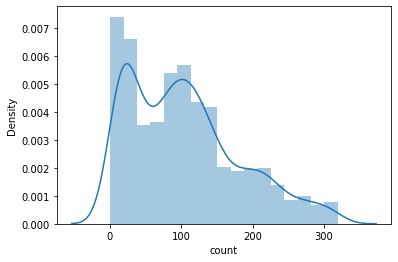

In [ ]:
# check skewness and kurtosis

sns.distplot(train['count'])

print('skewness: {}'.format(train['count'].skew()))
print('kurtosis: {}'.format(train['count'].kurt()))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness: -1.0474568904236035
kurtosis: 0.979098370349992


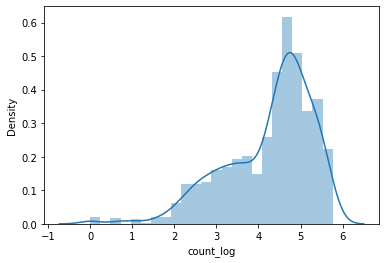

In [ ]:
train['count_log'] = train['count'].map(lambda x:np.log(x) if x>0 else 0)

sns.distplot(train['count_log'])

print('skewness: {}'.format(train['count_log'].skew()))
print('kurtosis: {}'.format(train['count_log'].kurt()))

train.drop('count', axis = 1, inplace = True)

In [ ]:
# predict for pm2.5 with values of 0 with random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

def predict_variable(data, var):
    data_pm2_0 = data.loc[data[var] == 0]
    data_pm2_Not0 = data.loc[data[var] != 0]
    wcol = ['temperature', 'humidity', 'visibility', 'windspeed']
    
    data_pm2_Not0[var] = data_pm2_Not0[var].astype("str")
    rf_pm = RandomForestClassifier()
    #rf_pm = GradientBoostingClassifier()
    rf_pm.fit(data_pm2_Not0[wcol], data_pm2_Not0[var])
    pm2_0 = rf_pm.predict(X = data_pm2_0[wcol])

    predict_pm_0 = data_pm2_0
    predict_pm_Not0 = data_pm2_Not0

    predict_pm_0[var] = pm2_0

    data = predict_pm_Not0.append(predict_pm_0)

    data[var] = data[var].astype('float')

    data.reset_index(inplace = True)
    data.drop("index", inplace = True, axis = 1)

    return data

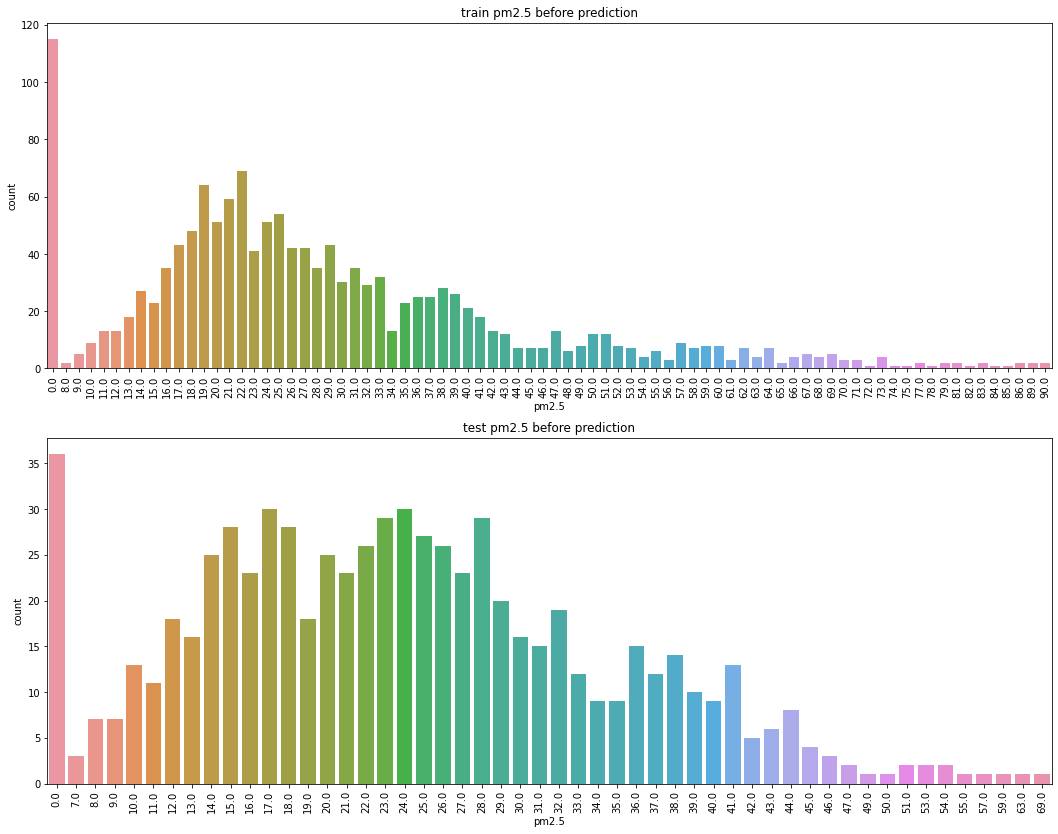

In [ ]:
# pm2.5 before prediciton
fig, axes = plt.subplots(nrows = 2, figsize = (18, 14))

plt.sca(axes[0])
plt.xticks(rotation=90)
axes[0].set(title = 'train pm2.5 before prediction')
sns.countplot(data = train, x = 'pm2.5', ax = axes[0])

plt.sca(axes[1])
plt.xticks(rotation=90)
axes[1].set(title = 'test pm2.5 before prediction')
sns.countplot(data = test, x = 'pm2.5', ax = axes[1])

<ipython-input-949-6cd71152a6d9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pm2_Not0[var] = data_pm2_Not0[var].astype("str")
<ipython-input-949-6cd71152a6d9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_pm_0[var] = pm2_0
<ipython-input-949-6cd71152a6d9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

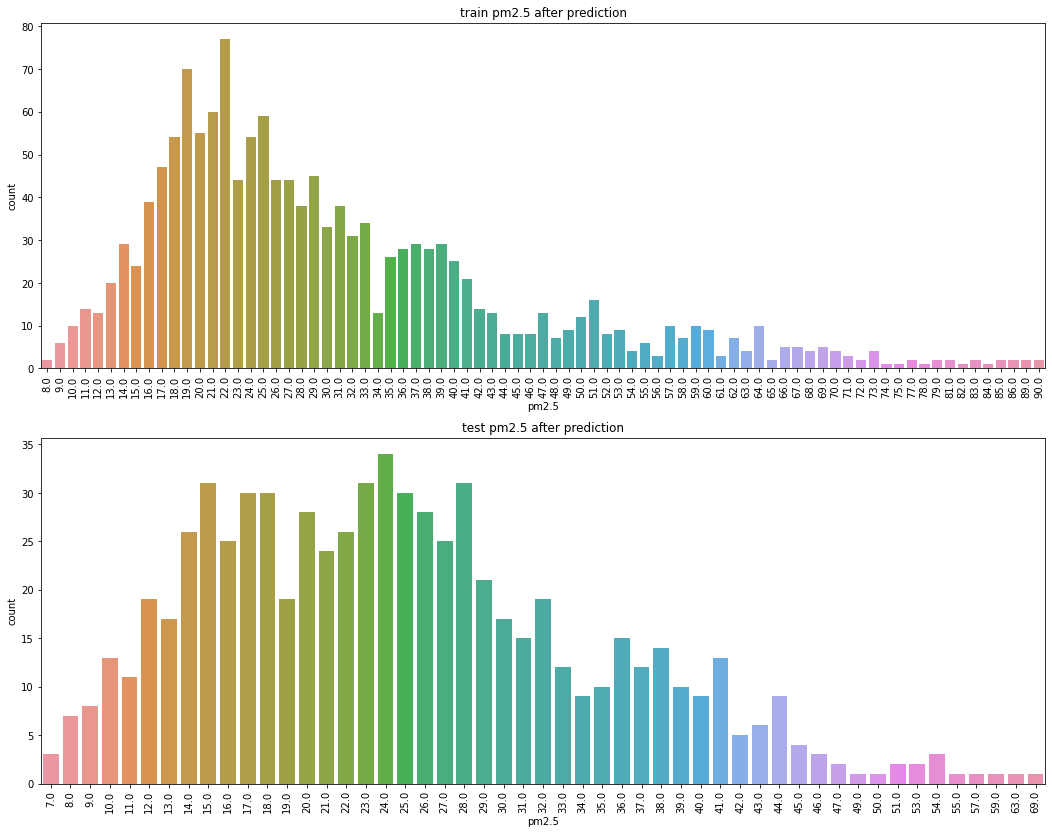

In [ ]:
# pm2.5 after prediction
train = predict_variable(train, 'pm2.5')
test = predict_variable(test, 'pm2.5')

fig, axes = plt.subplots(nrows = 2, figsize = (18, 14))

plt.sca(axes[0])
plt.xticks(rotation=90)
axes[0].set(title = 'train pm2.5 after prediction')
sns.countplot(data = train, x = 'pm2.5', ax = axes[0])

plt.sca(axes[1])
plt.xticks(rotation=90)
axes[1].set(title = 'test pm2.5 after prediction')
sns.countplot(data = test, x = 'pm2.5', ax = axes[1])

<ipython-input-949-6cd71152a6d9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pm2_Not0[var] = data_pm2_Not0[var].astype("str")
<ipython-input-949-6cd71152a6d9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_pm_0[var] = pm2_0
<ipython-input-949-6cd71152a6d9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

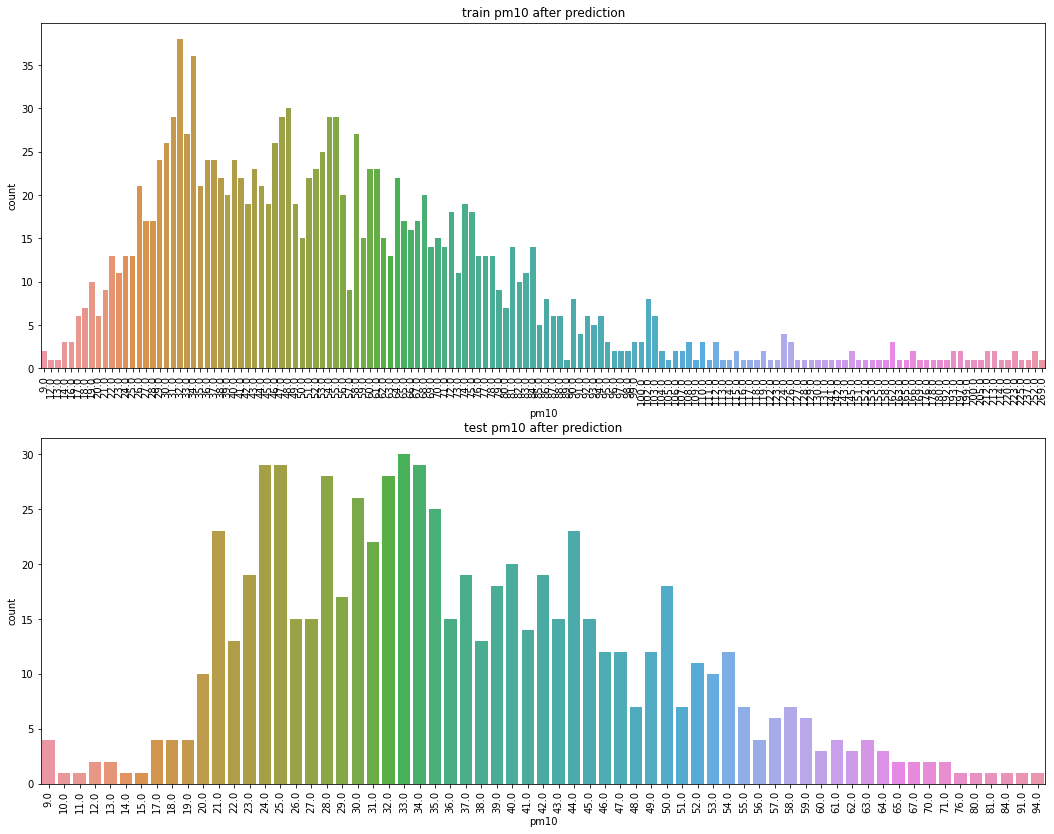

In [ ]:
train = predict_variable(train, 'pm10')
test = predict_variable(test, 'pm10')

fig, axes = plt.subplots(nrows = 2, figsize = (18, 14))

plt.sca(axes[0])
plt.xticks(rotation=90)
axes[0].set(title = 'train pm10 after prediction')
sns.countplot(data = train, x = 'pm10', ax = axes[0])

plt.sca(axes[1])
plt.xticks(rotation=90)
axes[1].set(title = 'test pm10 after prediction')
sns.countplot(data = test, x = 'pm10', ax = axes[1])

<ipython-input-949-6cd71152a6d9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pm2_Not0[var] = data_pm2_Not0[var].astype("str")
<ipython-input-949-6cd71152a6d9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_pm_0[var] = pm2_0
<ipython-input-949-6cd71152a6d9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

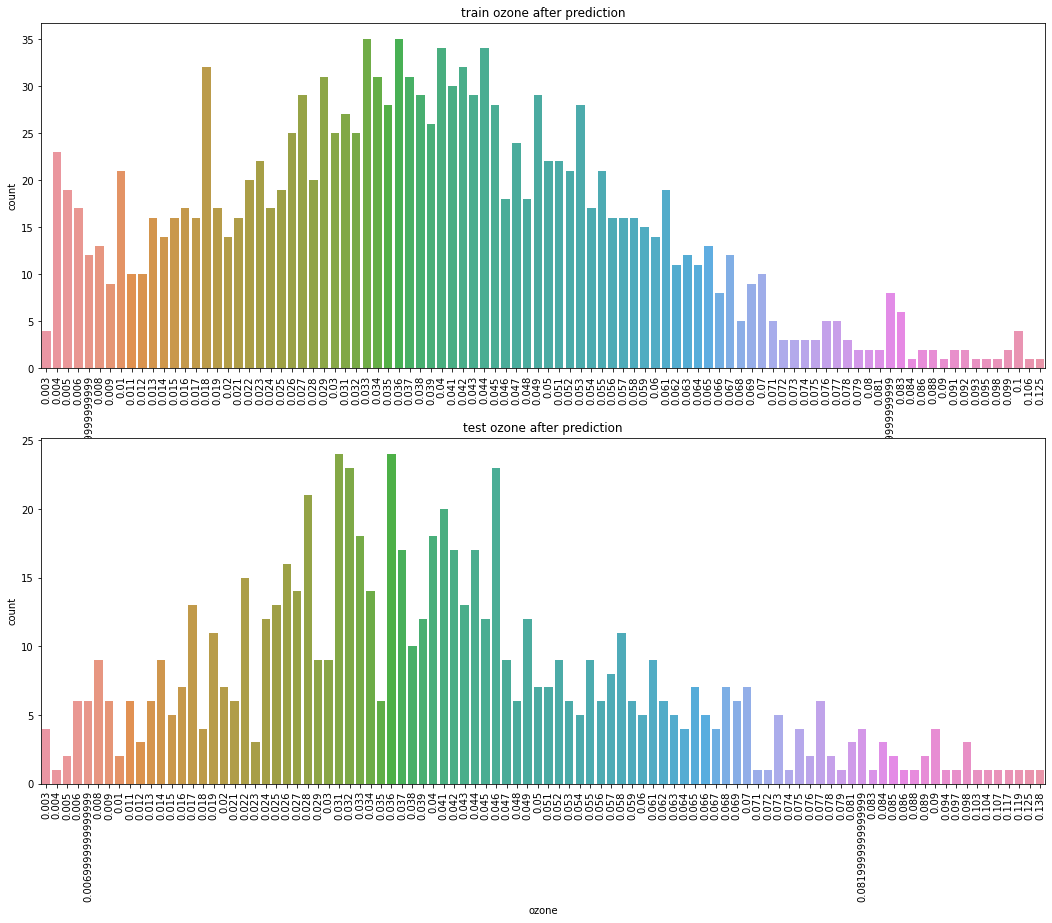

In [ ]:
train = predict_variable(train, 'ozone')
test = predict_variable(test, 'ozone')

fig, axes = plt.subplots(nrows = 2, figsize = (18, 14))

plt.sca(axes[0])
plt.xticks(rotation=90)
axes[0].set(title = 'train ozone after prediction')
sns.countplot(data = train, x = 'ozone', ax = axes[0])

plt.sca(axes[1])
plt.xticks(rotation=90)
axes[1].set(title = 'test ozone after prediction')
sns.countplot(data = test, x = 'ozone', ax = axes[1])

In [ ]:
test = test.sort_values(by=['id']).reset_index(drop = True)

In [ ]:
test

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0
...,...,...,...,...,...,...,...,...,...,...
710,2148,1,24.6,0.0,2.4,60.0,1745.0,0.057,36.0,35.0
711,2149,1,18.1,0.0,1.0,55.0,2000.0,0.044,35.0,18.0
712,2165,9,23.3,0.0,2.3,66.0,1789.0,0.020,17.0,15.0
713,2166,16,27.0,0.0,1.6,46.0,1956.0,0.032,40.0,26.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness: 2.387182859271928
kurtosis: 8.880542768840897


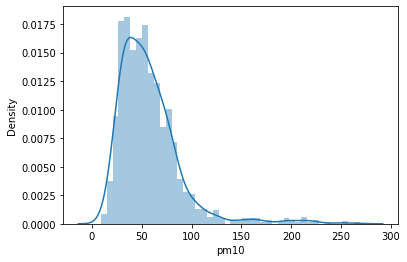

In [ ]:
# apply log to 'count'
var = 'pm10'

sns.distplot(train[var])

print('skewness: {}'.format(train[var].skew()))
print('kurtosis: {}'.format(train[var].kurt()))


In [ ]:

train['pm10_log'] = train['pm10'].map(lambda x:np.log(x) if x>0 else 0)
test['pm10_log'] = test['pm10'].map(lambda x:np.log(x) if x>0 else 0)

train['pm2.5_log'] = train['pm2.5'].map(lambda x:np.log(x) if x>0 else 0)
test['pm2.5_log'] = test['pm2.5'].map(lambda x:np.log(x) if x>0 else 0)

#sns.distplot(train['windspeed_log'])

#print('skewness: {}'.format(train['windspeed_log'].skew()))
#print('kurtosis: {}'.format(train['windspeed_log'].kurt()))

train.drop(['pm10', 'pm2.5'], axis = 1, inplace = True)
test.drop(['pm10', 'pm2.5'], axis = 1, inplace = True)

In [ ]:
'''train.drop(['id', 'precipitation'], axis = 1, inplace = True)
test.drop(['id', 'precipitation'], axis = 1, inplace = True)'''

train.drop(['id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)

In [ ]:
from imblearn.over_sampling import SMOTE

X = train.drop('precipitation', axis = 1).values
y = train['precipitation'].values
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


In [ ]:
train = pd.DataFrame(X_res, columns = train.drop('precipitation', axis = 1).columns)
train['precipitation'] = y_res

In [ ]:
train

,hour,temperature,windspeed,humidity,visibility,ozone,count_log,pm10_log,pm2.5_log,precipitation
0,20.000000,16.300000,1.500000,89.000000,576.000000,0.027000,3.891820,4.330733,3.496508,1.0
1,13.000000,20.100000,1.400000,48.000000,916.000000,0.042000,5.068904,4.290459,3.688879,0.0
2,6.000000,13.900000,0.700000,79.000000,1382.000000,0.033000,3.258097,3.465736,2.944439,0.0
3,23.000000,8.100000,2.700000,54.000000,946.000000,0.040000,4.043051,4.317488,4.158883,0.0
4,2.000000,13.600000,1.700000,80.000000,1073.000000,0.027000,3.663562,3.526361,2.708050,0.0
...,...,...,...,...,...,...,...,...,...,...
2775,16.439830,10.358927,1.736102,64.638981,1933.713230,0.050693,4.112726,3.714976,3.620748,1.0
2776,2.811928,11.571789,0.404355,89.811928,285.034397,0.012915,1.756944,4.194281,3.976206,1.0
2777,16.286658,10.498679,1.792338,75.490090,1868.388411,0.047720,4.269262,3.586272,3.353920,1.0
2778,7.302373,14.296697,1.860784,94.970072,352.996902,0.021880,4.071686,3.449284,3.000839,1.0


In [ ]:
p = test['precipitation'].values
test = test.drop('precipitation', axis = 1)
test['precipitation'] = p

In [ ]:
test

,hour,temperature,windspeed,humidity,visibility,ozone,pm10_log,pm2.5_log,precipitation
0,7,20.7,1.3,62.0,954.0,0.041,3.784190,3.295837,0.0
1,17,30.0,5.4,33.0,1590.0,0.061,3.891820,3.583519,0.0
2,13,19.0,2.1,95.0,193.0,0.020,3.583519,3.332205,1.0
3,6,22.5,2.5,60.0,1185.0,0.027,3.951244,3.637586,0.0
4,22,14.6,3.4,93.0,218.0,0.041,2.890372,2.708050,1.0
...,...,...,...,...,...,...,...,...,...
710,1,24.6,2.4,60.0,1745.0,0.057,3.583519,3.555348,0.0
711,1,18.1,1.0,55.0,2000.0,0.044,3.555348,2.890372,0.0
712,9,23.3,2.3,66.0,1789.0,0.020,2.833213,2.708050,0.0
713,16,27.0,1.6,46.0,1956.0,0.032,3.688879,3.258097,0.0


## Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train = train.drop('count_log', axis = 1).values
target_label = train['count_log'].values
X_test = test.values

X_tr, X_val, y_tr, y_val = train_test_split(X_train, target_label, test_size = 0.2, random_state = 2000)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

#model = RandomForestRegressor(n_estimators = 100)
model = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=5, 
                                   min_samples_leaf=15, min_samples_split=10, random_state =1) 
model.fit(X_tr, y_tr)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=15,
                          min_samples_split=10, n_estimators=2000,
                          random_state=1)

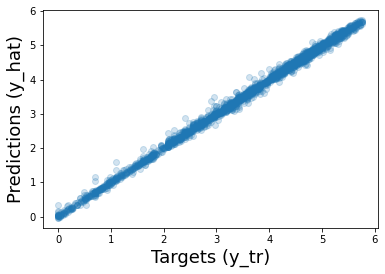

In [ ]:
y_hat = model.predict(X_tr)
plt.scatter(y_tr, y_hat, alpha = 0.2)
plt.xlabel('Targets (y_tr)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

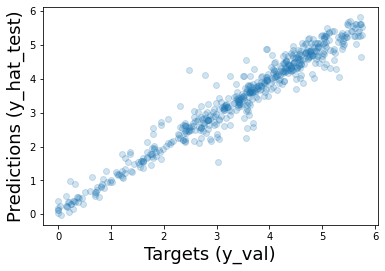

In [ ]:
y_hat_test = model.predict(X_val)
plt.scatter(y_val, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_val)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.show()

In [ ]:
score_train = model.score(X_tr, y_tr)
score_val = model.score(X_val, y_val)

print("train score: %f" %score_train)
print("validation score: %f" %score_val)

train score: 0.997119
validation score: 0.950873


## Hyperparameter Tuning

* https://educationalresearchtechniques.com/2019/01/14/gradient-boosting-regression-in-python/

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import tree

crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)

for depth in range (1,10):
    tree_regressor=tree.DecisionTreeRegressor(max_depth=depth,random_state=1)
    if tree_regressor.fit(X_tr, y_tr).tree_.max_depth<depth:
        break
        
    score=np.mean(cross_val_score(tree_regressor,X_tr, y_tr,scoring='neg_mean_squared_error', cv=crossvalidation,n_jobs=1))
    print(depth, score)

1 -1.3669002508614716
2 -0.9304220562107389
3 -0.6916913837774348
4 -0.4934518631392682
5 -0.39290657321432193
6 -0.3285490525350221
7 -0.2729025376409415
8 -0.2523842833825041
9 -0.2256021666830792


In [ ]:
GBR=GradientBoostingRegressor()
#search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[5, 10, 12, 14], 'random_state':[1]}
search=GridSearchCV(estimator=GBR,param_grid=search_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=crossvalidation)

search.fit(X_tr, y_tr)
search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 2000, 'random_state': 1}

## Predict

In [ ]:
pred = model.predict(test)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [ ]:
submission = pd.read_csv('data/따릉이/submission.csv')
submission

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN
...,...,...
710,2148,NaN
711,2149,NaN
712,2165,NaN
713,2166,NaN


In [ ]:
submission['count_log'] = pred
submission['count'] = np.exp(submission['count_log'])
submission.drop(['count_log'], axis = 1, inplace = True)
submission

,id,count
0,0,66.427064
1,1,225.995633
2,2,5.902889
3,4,25.854434
4,5,2.699515
...,...,...
710,2148,60.324263
711,2149,58.213503
712,2165,116.295686
713,2166,150.654365


In [ ]:
submission.to_csv('submission3.csv', index = False)

* Final score: 48.41375
* Takeaways
    * May need to consider multicollinearity
    * Investigate whether to use SMOTE oversampling or not
    * Make new features using existing variables (for example, discomfort index based on temperature and humidity)
    * Make use of scaling and standardizing
    * May predict better with date/weekday data